In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import interpolate
from scipy import integrate
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv
from math import sqrt
import csv
from math import cos,pi
import import_ipynb
import omcp
import a_n
import time
%run C:\Users\wbenn/Marshak_Wave_Scripts/Marshak_RZ/MarshakWave_1D.ipynb

importing Jupyter notebook from omcp.ipynb
importing Jupyter notebook from a_n.ipynb
a_n module loaded
0.20230236399143287
0.30006099606321834


In [2]:
# #import omega = 0 benchmark 

### This notebook solves the Marshak wave problem for a cylinder of radius R on a set of N+1 points between 0 and R. 

### PDE
let $\kappa = \kappa_0\kappa(r,z)$
Where $\kappa(r,z) = 1$ in the optically thin region and $100$ in the optically thick region. 
Since $\kappa$ is piecewise constant in r and z, the PDE reduces to,
$$  \frac{\partial e}{\partial t}\bigg{|}_{r=r_m} = K\left[\boldsymbol{\theta}\cdot\boldsymbol{\omega}  + \left( \frac{1}{\kappa_m}\frac{\partial^2 \theta_m}{\partial z^2}\right)\right]$$
Where $\kappa(r,z) = 1$ in the optically thin region and $100$ in the optically thick region. 
Assuming that I can write,
$$ \frac{1}{\kappa_m(z)}\frac{\partial^2}{\partial z^2}\theta_m(z) =\frac{1}{\kappa_i}\left(\theta_{i+1}-2\theta_i+\theta_{i-1}\right) $$ 

### Building the omega matrix 
$$\omega_{mn} = \frac{1}{\kappa_m}\left(\left[\frac{-\frac{\partial}{\partial r} a_n(r)}{\frac{3\kappa_0}{2}\left(\frac{1-\alpha}{1+\alpha}\right)+\frac{\partial}{\partial r}a_0(r)}\right]\bigg{|}_{r=R}\left[\frac{1}{r_m}\frac{\partial a_0}{\partial r}+\frac{\partial^2a_0}{\partial r^2}\right]+\left[\frac{1}{r_m}\frac{\partial a_n}{\partial r}+\frac{\partial^2a_n}{\partial r^2}\right]\right)\bigg{|}_{r=r_m}.$$ 

### Boundary conditions
@ z=0, $\overline{\theta}_0 = 1$

@ z = L, $\overline{\theta}_{I+1} = 0$ 

In [3]:
#constants
c=29.998     #cm/ns
a=0.01372

In [4]:
#set up mesh 
R = 2.0   # Radius of cylinder  
L = 7
t_final = 10
I = 100 #1400 gives 0.005
dz = L/I
#parameters
rho_thin = 0.01
rho_thick = 0.01
# rho_thick = rho_thin
sigma = 20.0
kappa_thin = rho_thin*sigma
kappa_thick = rho_thick*sigma
cv_thick = rho_thick*0.05
cv_thin = rho_thin*0.05
T0=5          #driving temperature (kev)
Tm0 = 0.05      # material initial temperature
n = 0
alpha = 0
alph_frac = (1-alpha)/(1+alpha)
# collocation points
N=5 #The omega matrix is NxN, there are N+1 collocation points
#Setting up mesh for plotting
z = np.linspace(0,L+dz,num = int(I+1))
r_grid = np.linspace(0,R,50)
r_index = len(r_grid)
sol_3D_N = np.zeros((I+1,r_index))  
xn = np.zeros(N+1) 
rn = np.zeros(N+1) 
for i in range(0,N+1):
        xn[i] = cos(2*pi*i/(2*N+1))
        rn[i] = sqrt(R**2*(xn[i]+1)/2)

# #constants for scaling marshak solution
# A = sqrt(1/(2*K)) 
# zm = sqrt(t_final)/A
pars = [rho_thin,rho_thick,sigma,dz]

In [5]:
#Finding the harmonic mean of the difussion coefficient 
Dt = 1/(3*kappa_thick)
Di = 1/(3*kappa_thin)
# kavg = 2*kappa_thin*kappa_thick/(kappa_thin+kappa_thick)
kavg = (3*(2*Di*Dt/(Di+Dt)))**(-1) 
cvavg = (2*cv_thin*cv_thick/(cv_thin+cv_thick))
def kappa_func(xx1,rr):
#     if xx1*dz<=2.5:
#         return kappa_thin, cv_thin
#     if xx1*dz>= 2.5:
#         return kappa_thick, cv_thick
    zz = xx1*dz
    ########################################
    if zz < 2.5 or zz > 4.5:
        if rr < 0.5:
            return kappa_thin
        if rr> 0.5:
            return kappa_thick
        if rr == 0.5:
            return kavg
    #########################################
    if (zz > 2.5 and zz < 3.0) or (zz > 4.0 and zz < 4.5):
        if rr < 1.5:
            return kappa_thin
        if rr > 1.5:
            return kappa_thick
        if rr == 1.5:
            return kavg
    #########################################
    if zz > 3.0 and zz < 4.0:
#     if zz > 2.5:
#         return kappa_thick
        if rr < 1.0:
            return(kappa_thick)
        if (rr > 1.0 and rr < 1.5):
            return(kappa_thin)
        if rr == 1.0:
            return(kavg)
        if rr > 1.5:
            return kappa_thick
    ##########################################
    if (zz == 2.5 and rr> 0.5 and rr< 1.5):
        return(kavg)
    if (zz == 4.5 and rr> 0.5 and rr< 1.5):
        return(kavg)
    if (zz == 3.0 and rr< 1.0):
        return(kavg)
def cv_func(xx1,rr):
    zz = xx1*dz
    ########################################
    if zz < 2.5 or zz > 4.5:
        if rr < 0.5:
            return cv_thin
        if rr> 0.5:
            return cv_thick
        if rr == 0.5:
            return cvavg
    #########################################
    if (zz > 2.5 and zz < 3.0) or (zz > 4.0 and zz < 4.5):
        if rr < 1.5:
            return cv_thin
        if rr > 1.5:
            return cv_thick
        if rr == 1.5:
            return cvavg
    #########################################
    if zz > 3.0 and zz < 4.0:
#     if zz >2.5:
#         return cv_thick
        if rr < 1.0:
            return(cv_thick)
        if (rr > 1.0 and rr < 1.5):
            return(cv_thin)
        if rr == 1.0:
            return(cvavg)
        if rr > 1.5:
            return cv_thick
    ##########################################
    if (zz == 2.5 and rr> 0.5 and rr< 1.5):
        return(cvavg)
    if (zz == 2.5 and rr< 0.5):
        return cv_thin
    if (zz == 2.5 and rr>= 1.5):
        return cv_thick
    if (zz == 4.5 and rr> 0.5 and rr< 1.5):
        return(cvavg)
    if (zz == 4.5 and rr< 0.5):
        return cv_thin
    if (zz == 3.0 and rr< 1.0):
        return(cvavg)
kappa_edge = 0.01*20
print(kappa_edge)

0.2


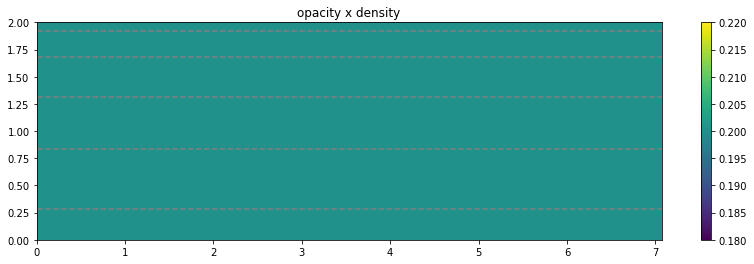

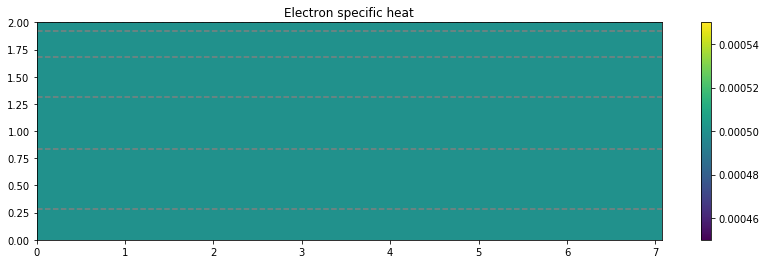

In [6]:
def r_func(x1):
    if x1< z_index_1 or z_index_4<x1:
        return(0,0.5)
    if z_index_1<=x1<z_index_2 or z_index_3<x1<=z_index_4:
        return(.5,1.5)
    if z_index_2<=x1<=z_index_3:
        return(1.0,1.5)
    
kappa_3D = np.zeros((I+1,r_index))
cv_3D = np.zeros((I+1,r_index))
kappa = 0
for j in range(0,r_index):
    for i in range(0,I+1):
#         r1 = r_func(i)[0]
#         r2 = r_func(i)[1]
        rrr = r_grid[j]
        kappa = kappa_func(i,rrr)
#         kappa_3D[i,j] = omcp.kappa_func2(i,j,r1,r2,zlist,r_grid,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[0]
        kappa_3D[i,j] = kappa
        cv_3D[i,j] = cv_func(i,rrr)

plt.figure(figsize=(14,4))
plt.pcolormesh(z,r_grid,np.transpose(kappa_3D))
for i in range(0,len(rn)):
    lis = np.ones(len(z))*rn[i]
    plt.plot(z,lis,"--",c="gray",label="r = rn %.0f"%i)
#     plt.legend(loc="upper right")
plt.colorbar()
plt.title("opacity x density")
plt.savefig("wall test 2")
plt.show()
plt.figure(figsize=(14,4))
plt.pcolormesh(z,r_grid,np.transpose(cv_3D))
for i in range(0,len(rn)):
    lis = np.ones(len(z))*rn[i]
    plt.plot(z,lis,"--",c="gray",label="r = rn %.0f"%i)
#     plt.legend(loc="upper right")
plt.colorbar()
plt.title("Electron specific heat")
plt.show()
# omcp.kappa_func2(0,12,0,0.5,zlist,rn)

In [7]:
omega_1 = omcp.omega_func(kappa_edge,N,R,alpha,1,xn,rn,pars)
print(omega_1)

[[-25.72249993  24.11179492   0.72298324  -1.32058032   0.47176018]
 [ 21.79691676 -34.75612042  15.20288302  -2.68081137   0.56129575]
 [ -2.97808196  14.12578084 -18.02908824   7.86837819  -1.01911632]
 [  1.23820813  -3.60288309  10.58490531 -12.39227869   4.18952214]
 [ -1.7356888    4.17719308  -6.41594544  14.3862148  -10.4399142 ]]


In [8]:
V_0 = np.zeros((I+1,N,2)) # initial condition vector
# for j in range(0,rn_index_1+1):
for j in range(0,N):
    for i in range(0,int(I+1)):
#         if i ==0 and rn[j+1] <= 0.5:
# #         if i ==0:
#             V_0[i,j,:] = 0.05
#         else:
            V_0[i,j,1] = 1e-8
            V_0[i,j,0] = 1e-8
#             if rn[j+1]<=0.5:
#             V_0[0,j,1] = 0.3
#             V_0[0,j,0] = a*0.3**4
V_0 = np.reshape(V_0,(N*(I+1)*2))
print("N = %.0f"%N,"Size of domain is",L,"(cm).","There are", I,"zones","dz = ",dz,".", "running until t =", t_final,"(ns).")

N = 5 Size of domain is 7 (cm). There are 100 zones dz =  0.07 . running until t = 10 (ns).


In [9]:
vv = np.zeros(N*(I+1)*2)
Tb = a*T0**4
idz2 = (1/dz**2)
def rhs(t, vv):
    v = np.reshape(np.copy(vv),((I+1),N,2))
    rhs = np.zeros((I+1,N,2))
    for j in range(0,N):
        for i in range(0,I+1):
#             kappa = omcp.kappa_func(i,j+1,r1,r2,rn,zlist,pars)[0]
            kappa = kappa_func(i,rn[j+1])
#             cv =    omcp.kappa_func(i,j+1,r1,r2,rn,zlist,pars)[1]
            cv = cv_func(i,rn[j+1])
            omega = omega_1[j,:]
            dotproduct = np.dot(omega,v[i,:,0])
            cc2 = (3*kappa*dz)/(2)
            ######################################################################
            if i < 1:
                cavg_p = .5*(3*v[0,j,0]-v[1,j,0])
                cdif_bc = (v[1,j,0]-v[0,j,0])+cc2*(Tb-cavg_p)
                rhs[i,j,0] = (c/(3*kappa))*(dotproduct + idz2*(cdif_bc)) + c*kappa*(a*v[i,j,1]**4-v[i,j,0])
                rhs[i,j,1] = -(c*kappa/cv)*(a*v[i,j,1]**4-v[i,j,0])
#           ######################################################################
            if i > I-1:
                cavg_p = .5*(3*v[I-1,j,0]-v[I,j,0])
                cdif_vac = -cc2*(cavg_p) - (v[I,j,0]-v[I-1,j,0])
                rhs[i,j,0] = (c/(3*kappa))*(dotproduct + idz2*(cdif_vac)) + c*kappa*(a*v[i,j,1]**4-v[i,j,0])
                rhs[i,j,1] = -(c*kappa/cv)*(a*v[i,j,1]**4-v[i,j,0])
            ######################################################################
            if i > 0 and i < I:
                cdif2 = v[i+1,j,0] - 2*v[i,j,0] + v[i-1,j,0]
                rhs[i,j,0] = (c/(3*kappa))*(dotproduct + idz2*(cdif2)) + c*kappa*(a*v[i,j,1]**4-v[i,j,0])
                rhs[i,j,1] = -(c*kappa/cv)*(a*v[i,j,1]**4-v[i,j,0])
            
    return np.reshape(rhs,(N*(I+1)*2)) 

### Solver

In [10]:
reltol = 1e-3
abstol = 1e-5
sol = integrate.solve_ivp(rhs,[0,t_final],V_0,method = "BDF",rtol=reltol,atol=abstol)

### Reshape solution

In [11]:
#RZ 
z = np.linspace(0,L+dz,num = int(I+1)) 
t_index = np.size(sol.t)-1
t_index2 = np.size(sol.t)-1
t_index3 = np.size(sol.t)-1    # last timestep
ysolnew = np.reshape(sol.y[:,t_index],(I+1,N,2)) #solution at last timestep 

K = a*c/(3*kappa_thin*cv_thin)
#constants for scaling marshak solution
A = sqrt(1/(2*K)) 
z1 = sqrt(t_final)/A

marshak_x=np.ndarray.tolist(sol_marshak.t*z1)
marshak_T = np.ndarray.tolist(sol_marshak.y[0])


### Plot lineouts in z at collocation points 

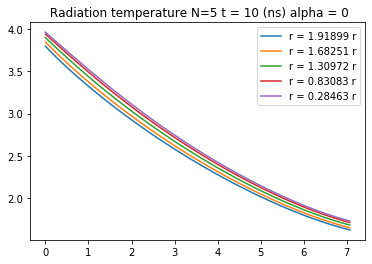

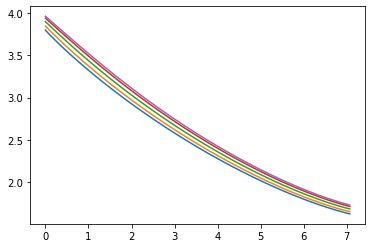

In [12]:
# plt.plot(marshak_x,marshak_T,"--", label="benchmark")

# plt.legend(loc="upper right")
plt.title(" Radiation temperature N=%.0f t = %.0f (ns) alpha = %.0f"%(N,t_final,alpha))
# RZ solution 
for i in range(0,N):
    plt.plot(z[:], (ysolnew[:,i,0]/a)**0.25,"-",label ="r = %.5f r"%(rn[i+1]) )
    plt.legend(loc="upper right")
plt.savefig("R2_thick_wall_alpha_%.0f.jpg"%alpha)
plt.legend()
plt.show()

for i in range(0,N):
    plt.plot(z[:], ysolnew[:,i,1],"-",label ="r = %.5f r"%(rn[i+1]) )
#     plt.plot(z[:], ysolnew[:,i,1],"--",label ="r = %.5f m"%(rn[i+1]) )
# plt.plot(marshak_x,marshak_T,label ="benchmark")
# plt.legend(loc="upper right")
# plt.title("Material temperature N=%.0f t = %.0f (ns)"%(N,t_final))
plt.show()
# RZ solution 

# plt.plot(marshak_x,marshak_T,label ="benchmark")
# plt.legend(loc="upper right")

# RZ solution 
# for i in range(0,N):
#     plt.plot(z[:], ysolnew2[:,i,0],"-",label ="r = %.5f r"%(rn[i+1]) )
#     plt.plot(z[:], ysolnew2[:,i,1],"--",label ="r = %.5f m"%(rn[i+1]) )
# # plt.plot(marshak_x,marshak_T,label ="benchmark")
# plt.legend(loc="upper right")
# plt.title("N=%.0f RZ Solution t = %.1f"%(N,t_index3))
# plt.xlim(0,1)
plt.show()


### Finding solution as a function of r
$$T(r,z) = \left(a_0\frac{-\sum_1^N T^4(r_n)\frac{d}{dr} a_n(r)}{\frac{3\kappa}{2}\frac{1-\alpha}{1+\alpha}+\frac{d}{dr}a_0(r)}\bigg{|}_{r=r_0} + \sum_1^N a_n T^4(r_n)\right)^{1/4}$$

### Collocation solution at r points for numerical test

### 3D Solution

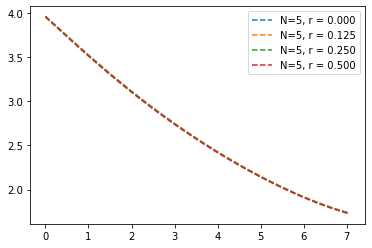

In [13]:
points = [0,0.125,0.25,0.5]
rlist = [1,2,3,4]
r_grid = np.linspace(0,R,250)
r_index = len(r_grid)
sol_col = np.zeros((I+1,4))
t0= time.perf_counter()
# define functions of r to call the an's, then just sum all of the solution values times the functions instead of creating a 
# function to do it 
Tr3D = np.zeros((I+1,r_index))


a1 = a_n.an_func(rn[0],N,R)[1,0]
for k in range(0,r_index):
    kappa = kappa = kappa_func(i,R) # opacity at boundary 
    r_sum = np.zeros(I+1)
    r = r_grid[k]
    a0 = a_n.an_func(r,N,R)[0,0]
    for j in range(0,N): 
#         r1 = r_func(j+1)[0]
#         r2 = r_func(j+1)[1]
        ar1 = a_n.an_func(rn[0],N,R)[1,j+1]
        ar0 = a_n.an_func(r,N,R)[0,j+1]
        r_sum += -a0*((ysolnew[:,j,0]))*ar1/(3*kappa/2*alph_frac + a1) + ar0*(ysolnew[:,j,0])
#     Tr3D[:,k] = (np.abs(r_sum)/a)**0.25*np.sign(r_sum)
    Tr3D[:,k] = ((r_sum)/a)**0.25

for k in range(0,4):
#     kappa = omcp.kappa_func(0,1,r1,r2,rn,zlist,pars)[0] # opacity at boundary 
    kappa = kappa_func(i,rn[j+1])
    r_sum = np.zeros(I+1)
    r = points[k]
    a0 = a_n.an_func(r,N,R)[0,0]
    for j in range(0,N): 
#         r1 = r_func(j+1)[0]
#         r2 = r_func(j+1)[1]
        ar1 = a_n.an_func(rn[0],N,R)[1,j+1]
        ar0 = a_n.an_func(r,N,R)[0,j+1]
        r_sum += -a0*((ysolnew[:,j,0]))*ar1/(3*kappa/2*alph_frac + a1) + ar0*(ysolnew[:,j,0])
    sol_col[:,k] = ((r_sum)/a)**0.25


for i in range(0,len(points)):
#     r_index = np.argmin(abs(r_grid- R*points[i]))
    plt.plot(z[:], sol_col[:,i],"--",label =r"N=%.0f, r = %.3f"%(N,points[i]))
#     #Output to CSV
    with open('crooked_pipe_t%.0f_r_%.0f'%(t_final,rlist[i]), 'w', ) as myfile: 
        wr = csv.writer(myfile, quoting=csv.QUOTE_NONE, lineterminator = '\n',escapechar='')
        for j in range(0,I+1):
            wr.writerow([z[j],sol_col[j,i]])
    
plt.legend(loc="upper right")


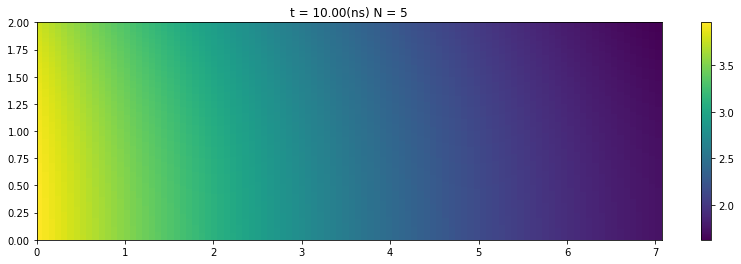

6.084398099999987


In [14]:
plt.figure(figsize=(14,4))
plt.pcolormesh(z,r_grid,np.transpose(Tr3D))
plt.colorbar()
plt.savefig("t_%.1f(ns)_N_%.0f.jpg"%(t_final,N))
plt.title("t = %.2f(ns) N = %.0f"%(t_final,N))
plt.show()
t1 = time.perf_counter()-t0
print(t1)

In [15]:
# zslice = np.argmin(abs(z-.0))
# sol_3D_rslice = np.zeros(r_index)
# for i in range(0,25):
#         sol_3D_rslice[i] = sol_3D_N[zslice,i] 

# plt.plot(r_grid,sol_3D_rslice)
# # plt.savefig("zslice_z_%.2f_N_%.0f_alpha_%.1f_.jpg"%(.05,N,alpha))
# # print(sol_3D_N[zslice,:])

### RHS function with fourth order difference

In [16]:
# #define rhs to solve ODE on each interval from 0 to L 
# vv = np.zeros(N*(I+1)*2)
# # v = np.reshape(np.copy(vv),((I+1),N,2))**4
# def rhs(t, vv):
#     v = np.reshape(np.copy(vv),((I+1),N,2))
#     rhs = np.zeros((I+1,N,2))
#     idz2 = (1/dz**2)
#     for j in range(0,N):
#         for i in range(0,1):
#             r1 = r_func(i)[0]
#             r2 = r_func(i)[1]
#             kappa = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[0]
#             cv = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[1]
#             omega = zone_select(i,j)
#             dotproduct = np.dot(omega,v[i,:,0])
#             Tb = a*0.3**4
#             cc2 = (3*kappa*dz)/(2)
#             rhs[i,j,0] = (c/(3*kappa*cv))*(dotproduct + idz2*((v[1,j,0]-v[0,j,0])+cc2*(-.5*(3*v[0,j,0]-v[1,j,0])+Tb)))+(a*v[i,j,1]**4-v[i,j,0])
#             rhs[i,j,1]  = -(c*kappa/cv)*(a*v[i,j,1]**4-v[i,j,0])
#         for i in range(1,2):
#             r1 = r_func(i)[0]
#             r2 = r_func(i)[1]
#             kappa = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[0]
#             cv = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[1]
#             omega = zone_select(i,j)
#             dotproduct = np.dot(omega,v[i,:,0])
#             rhs[i,j,0] = (c/(3*kappa*cv))*((dotproduct)+(1/12)*idz2*(-v[i+2,j,0]+16*v[i+1,j,0]-30*v[i,j,0]+16*v[i-1,j,0]-v[i-1,j,0])+(a*v[i,j,1]**4-v[i,j,0])) 
#             rhs[i,j,1]  = -(c*kappa/cv)*(a*v[i,j,1]**4-v[i,j,0])
#         for i in range(I-1,I):
#             r1 = r_func(i)[0]
#             r2 = r_func(i)[1]
#             kappa = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[0]
#             cv = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[1]
#             omega = zone_select(i,j)
#             dotproduct = np.dot(omega,v[i,:,0])
#             rhs[i,j,0] = (c/(3*kappa*cv))*((dotproduct)+(1/12)*idz2*(-v[i+1,j,0]+16*v[i+1,j,0]-30*v[i,j,0]+16*v[i-1,j,0]-v[i-2,j,0])+(a*v[i,j,1]**4-v[i,j,0]))
#             rhs[i,j,1]  = -(c*kappa/cv)*(a*v[i,j,1]**4-v[i,j,0])
#         for i in range(2,I-1):
#             r1 = r_func(i)[0]
#             r2 = r_func(i)[1]
#             kappa = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[0]
#             cv = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[1]
#             omega = zone_select(i,j)
#             dotproduct = np.dot(omega,v[i,:,0])
#             rhs[i,j,0] = (c/(3*kappa*cv))*((dotproduct)+(1/12)*idz2*(-v[i+2,j,0]+16*v[i+1,j,0]-30*v[i,j,0]+16*v[i-1,j,0]-v[i-2,j,0])+(a*v[i,j,1]**4-v[i,j,0]))
#             rhs[i,j,1]  = -(c*kappa/cv)*(a*v[i,j,1]**4-v[i,j,0])
# #         for i in range(I-1,I):
# #             r1 = r_func(i)[0]
# #             r2 = r_func(i)[1]
# #             kappa = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[0]
# #             cv = omcp.kappa_func(i,j+1,r1,r2,zlist,rn,kappa_thin,kappa_thick,kavg,cv_thin,cv_thick)[1]
# #             omega = zone_select(i,j)
# #             dotproduct = np.dot(omega,v[i,:,0])
# #             Tb = a*0.3**4
# #             cc2 = (3*kappa*dz)/(2)
# #             rhs[i,j,0] = (c/(3*kappa*cv))*(dotproduct + idz2*((v[1,j,0]-v[0,j,0])+cc2*(-.5*(3*v[0,j,0]-v[1,j,0]))))+(a*v[i,j,1]**4-v[i,j,0])
# #             rhs[i,j,1]  = -(c*kappa/cv)*(a*v[i,j,1]**4-v[i,j,0])
                
#     return np.reshape(rhs,(N*(I+1)*2))

In [17]:
# z1 = 2.5
# z2 = 3.0
# z3 = 4.0
# z4 = 4.5
# i=0        
# for i in range(0,I+1):
#     if i*dz>= z1:
#         z_index_1 = i 
#         break
# i=0
# for i in range(0,I+1):
#     if i*dz>= z2:
#         z_index_2 = i 
#         break
# i=0
# for i in range(0,I+1):
#     if i*dz>= z3:
#         z_index_3 = i 
#         break 
# i=0
# for i in range(0,I+1):
#     if i*dz>= z4:
#         z_index_4 = i 
#         break
# i=0
# zlist = [dz,z_index_1,z_index_2,z_index_3,z_index_4]
# print(zlist)

In [18]:
# z1 = 2.5
# z2 = 3.0
# z3 = 4.0
# z4 = 4.5
# i=0        
# for i in range(0,I+1):
#     if i*dz>= z1:
#         z_index_1 = i 
#         break
# i=0
# for i in range(0,I+1):
#     if i*dz>= z2:
#         z_index_2 = i 
#         break
# i=0
# for i in range(0,I+1):
#     if i*dz>= z3:
#         z_index_3 = i 
#         break 
# i=0
# for i in range(0,I+1):
#     if i*dz>= z4:
#         z_index_4 = i 
#         break
# i=0
# zlist = [dz,z_index_1,z_index_2,z_index_3,z_index_4]
# print(zlist)